# Generating SN Ia lightcurves based on first simulated 30-day schedule 

This notebook shows how to load the output for Eric's survey simulator `ztf_sim` and generate SN Ia lightcurves for it using the SALT2 template. (Check out the other notebooks for examples how to simulate other transients.)

In [1]:
import warnings
## No annoying warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import simsurvey.cadence as simul

import simsurvey_tools as sst

In [2]:
# Load ZTF fields from file
fields = sst.load_ztf_fields()

# Load simulated survey from file
plan = simul.SurveyPlan(fields=fields, load_opsim='/path/to/long.db', 
                        band_dict={'1': 'desg', '2': 'desr'})

In [3]:
# To review the pointing schedule, you can use this table
plan.cadence

band,skynoise,field,RA,time,Dec
str4,float64,int64,float64,float64,float64
desr,796.214341107,620,107.75,57467.1255168,24.83077
desr,796.214341107,619,100.25,57467.1261806,24.83077
desr,796.214341107,667,104.65217,57467.1266981,31.75385
desr,796.214341107,618,92.7499999997,57467.1272231,24.83077
desr,796.214341107,617,85.2500000003,57467.1277515,24.83077
desr,796.214341107,616,77.7500000003,57467.1282467,24.83077
desr,796.214341107,616,77.7500000003,57467.1287097,24.83077
desr,796.214341107,664,81.1739100001,57467.1292454,31.75385
desr,796.214341107,663,73.3478299998,57467.1297404,31.75385


In [4]:
# Follow the same scheme as in the other examples notebook
instprop = {"desg":{"gain":1.,"zp":30,"zpsys":'ab'},
            "desr":{"gain":1.,"zp":30,"zpsys":'ab'},
            "desi":{"gain":1.,"zp":30,"zpsys":'ab'}}

mjd_range = (plan.cadence['time'].min(), plan.cadence['time'].max())

tr = simul.get_sn_generator([0.,0.2], ratekind="basic", 
                            dec_range=[-30,90],
                            mjd_range=[mjd_range[0] - 60, mjd_range[1] + 25])

survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)
    
lcs = survey.get_lightcurves(
    # This cell may give an error because of the progress bar widget.
    # Just delete the following line to fix this.
    progress_bar=True, notebook=True
)

Determining field IDs for all objects

Generating lightcurves



## Analysing the output

The output of `get_lightcurves()` is a `LightcurveCollection` object. Below are some examples how to assess survey statistics based on this.

The first skyplot shows all SNe that were active when a field was observed (but they may have been too faint to be detected). The second skyplot shows the SNe that had at least one $5\sigma$ detection. 

SNe pointed to: 10125 out of 14112


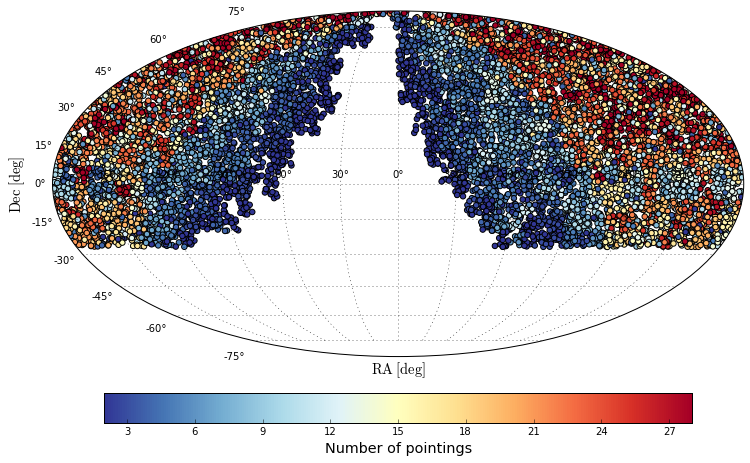

In [5]:
idx = lcs.meta['idx_orig']
n_obs = np.zeros(survey.generator.ntransient)
n_obs[idx] = np.array([len(a) for a in lcs])

survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of pointings", mask=idx)
print 'SNe pointed to: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

SNe detected: 4642 out of 14112


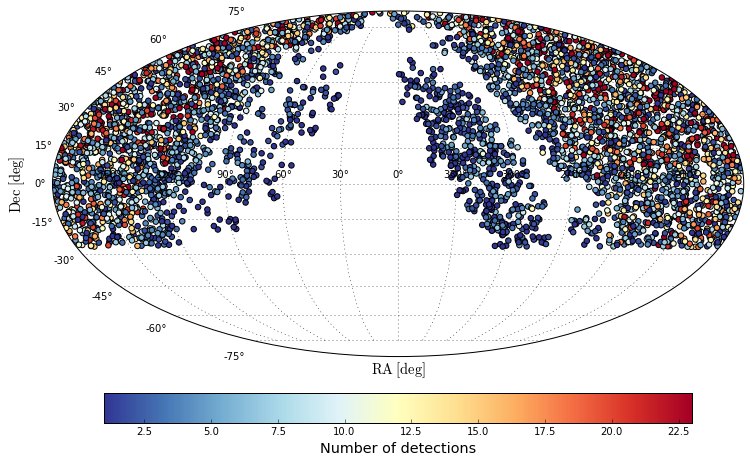

In [6]:
t_exp = -20

lcs_det = [lc[lc['flux']/lc['fluxerr'] > 5] for lc in lcs]
lcs_det = [lc[lc['time'] > t_exp*(1+lc.meta['z']) + lc.meta['t0']] for lc in lcs_det]

idx_det = lcs.meta['idx_orig'][np.array([len(lc) > 0 for lc in lcs_det])]
n_det = np.zeros(survey.generator.ntransient)
lcs_det = [lc for lc in lcs_det if len(lc) > 0]
n_det[idx_det] = np.array([len(a) for a in lcs_det])

survey.generator.show_skycoverage(cscale=n_det, cblabel="Number of detections", mask=idx_det)
print 'SNe detected: %i out of %i'%(np.sum(n_det > 0), survey.generator.ntransient)

In [7]:
z = np.array([lc.meta['z'] for lc in lcs_det])
p_i = np.array([lc['time'].min() - lc.meta['t0'] for lc in lcs_det])
p_e = np.array([lc['time'].max() - lc.meta['t0'] for lc in lcs_det])

The two last figures show how early the SNe are detected and at what redshift.

SNe found before peak: 2376


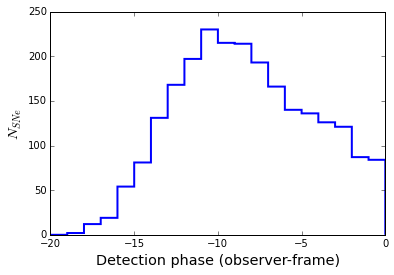

In [8]:
plt.hist(p_i, lw=2, histtype='step', range=(-20,0), bins=20)
print 'SNe found before peak:', np.sum(p_i < 0)
plt.xlabel('Detection phase (observer-frame)', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')

SNe found 14 observer-frame days before peak: 168
Local SNe (z < 0.1) found 14 observer-frame days before peak: 102


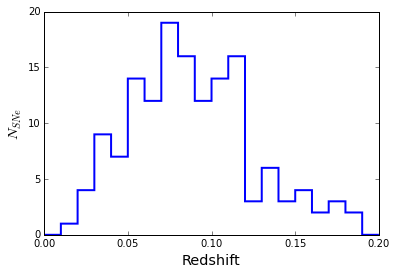

In [9]:
p_lim = -14
n = np.array([len(lc) for lc in lcs_det])
snr_max = np.array([max(lc['flux']/lc['fluxerr']) for lc in lcs_det])
plt.hist(z[(p_i < p_lim) & (snr_max >= 10)], lw=2, histtype='step', range=(0,0.2),bins=20)
print 'SNe found 14 observer-frame days before peak:', np.sum(p_i < p_lim) 
print 'Local SNe (z < 0.1) found 14 observer-frame days before peak:', np.sum((p_i < p_lim) & (z < 0.1))
plt.xlabel('Redshift', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')
_ = plt.xlim((0, 0.2))